# Tutorial 6a - Introduction to Coatings

### July 2024

This tutorial demonstrates how to apply coatings on surfaces in Optiland and how to assess their impact. Coatings impact the nature of light as it propagates through an optical system. For example, uncoated optics can result in significant light loss in a lens, especially if many surfaces are present.

In this tutorial, we will analyze only the so-called "Simple" coating type, which will be explained below. Future tutorials will introduce more complex coating types, including their relationship with polarization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from optiland import optic, coatings

Let's first define a simple doublet without coatings.

In [2]:
class Doublet(optic.Optic):
    def __init__(self):
        super().__init__()

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(index=1, radius=29.32908, thickness=0.7,
                         material='N-BK7', is_stop=True)
        self.add_surface(index=2, radius=-20.06842, thickness=0.032)
        self.add_surface(index=3, radius=-20.08770, thickness=0.5780,
                         material=('SF2', 'schott'))
        self.add_surface(index=4, radius=-66.54774, thickness=47.3562)
        self.add_surface(index=5)

        self.set_aperture(aperture_type='imageFNO', value=8.0)

        self.set_field_type(field_type='angle')
        self.add_field(y=0.0)
        self.add_field(y=0.7)
        self.add_field(y=1.0)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

        self.update_paraxial()
        self.image_solve()

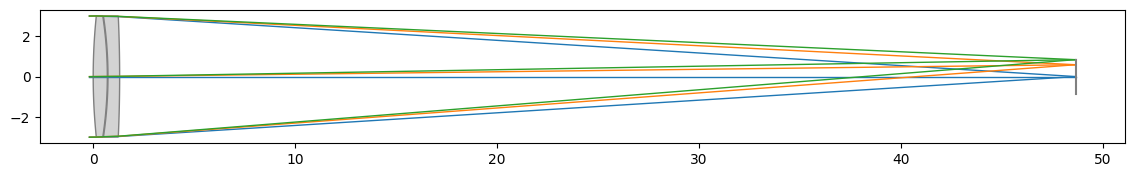

In [3]:
lens0 = Doublet()
lens0.draw(figsize=(14, 2))

We assess the energy transmitted through the system by first tracing rays through the doublet, then analyzing the resulting ray energy values at the image plane. This tutorial uses a similar approach to that shown in Tutorial 2a.

In [4]:
# trace rays through on-axis field point
lens0.trace(Hx=0, Hy=0, wavelength=0.55, num_rays=256, distribution='uniform')

num_surfaces = lens0.surface_group.num_surfaces

# take energies on last surface
energy = lens0.surface_group.energy[num_surfaces-1, :]

# compute average energy per ray
avg_energy = np.mean(energy)

print(f'Average energy per ray: {avg_energy:.5f}')

Average energy per ray: 1.00000


Let's also look at the histogram of all ray energies:

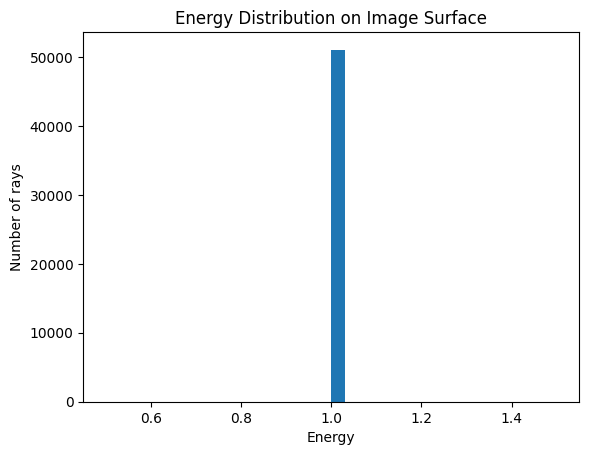

In [5]:
plt.hist(energy, bins=32)
plt.xlabel('Energy')
plt.ylabel('Number of Rays')
plt.title('Energy Distribution on Image Surface')
plt.show()

As we can see all rays have the exact same energy, which is 1. This is because no coatings have been applied to this lens, so no energy is lost on any surface. This isn't particularly interesting.

Let's now apply a "Simple" coating, which assigns a fixed transmittance and reflectance factor for each surface. Any ray incident on the surface will experience the same transmittance and reflectance. Let's assume the following transmittance values for each surface in our doublet:

- Surface 1: 50%
- Surface 2: 60%
- Surface 3: 80%
- Surface 4: 90%

We will assume the reflectance is simply 100% minus the transmittance.

In [6]:
class DoubletSimpleCoating(optic.Optic):
    def __init__(self):
        super().__init__()

        # define coatings here
        coating1 = coatings.SimpleCoating(transmittance=0.5, reflectance=0.5)
        coating2 = coatings.SimpleCoating(transmittance=0.6, reflectance=0.4)
        coating3 = coatings.SimpleCoating(transmittance=0.8, reflectance=0.2)
        coating4 = coatings.SimpleCoating(transmittance=0.9, reflectance=0.1)

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)

        # add coating 1 to surface 1
        self.add_surface(index=1, radius=29.32908, thickness=0.7,
                         material='N-BK7', is_stop=True, coating=coating1)
        
        # add coating 2 to surface 2
        self.add_surface(index=2, radius=-20.06842, thickness=0.032,
                         coating=coating2)

        # add coating 3 to surface 3
        self.add_surface(index=3, radius=-20.08770, thickness=0.5780,
                         material=('SF2', 'schott'), coating=coating3)
        
        # add coating 4 to surface 4
        self.add_surface(index=4, radius=-66.54774, thickness=47.3562,
                         coating=coating4)
        self.add_surface(index=5)

        self.set_aperture(aperture_type='imageFNO', value=8.0)

        self.set_field_type(field_type='angle')
        self.add_field(y=0.0)
        self.add_field(y=0.7)
        self.add_field(y=1.0)

        self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        self.add_wavelength(value=0.6563)

        self.update_paraxial()
        self.image_solve()

Let's now define our doublet with "Simple" coatings and perform the exact same analysis.

In [7]:
# define the lens0 with coatings
lens1 = DoubletSimpleCoating()

# trace rays through on-axis field point
lens1.trace(Hx=0, Hy=0, wavelength=0.55, num_rays=256, distribution='uniform')

num_surfaces = lens1.surface_group.num_surfaces

# take energies on last surface
energy_coating = lens1.surface_group.energy[num_surfaces-1, :]

# compute average energy per ray
avg_energy_coating = np.mean(energy_coating)

print(f'Average energy per ray: {avg_energy_coating:.5f}')

Average energy per ray: 0.21600


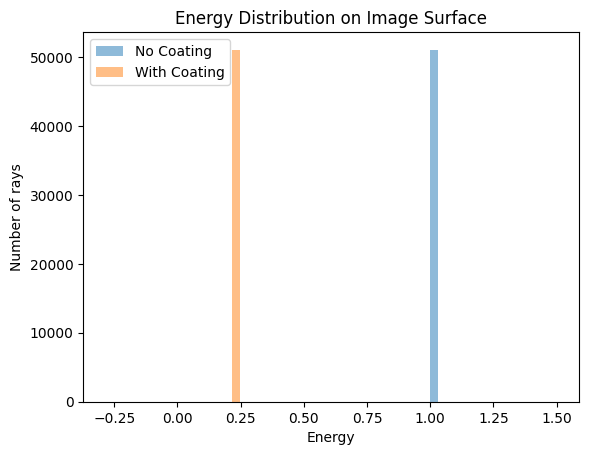

In [8]:
plt.hist(energy, bins=32, label='No Coating', alpha=0.5)
plt.hist(energy_coating, bins=32, label='With Coating', alpha=0.5)
plt.xlabel('Energy')
plt.ylabel('Number of Rays')
plt.title('Energy Distribution on Image Surface')
plt.legend()
plt.show()

The rays propagated through the lens with the coating now have the same value of 0.216, which is equal to 0.5 * 0.6 * 0.8 * 0.9, as expected. Compare this again to the nominal value of 1.0.

Conclusions:
- This tutorial introduced the concept of coatings in Optiland.
- The "SimpleCoating" class was demonstrated, which simply assigns a fixed energy loss during ray interaction with a surface.

The following tutorials will elaborate on the concepts of coatings and polarization in Optiland.